<a href="https://colab.research.google.com/github/adeangg/SkripsinyaAde/blob/main/GWO_FDDGM_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma

In [27]:
data_artikel_p = [692.4, 803.0, 852.7, 951.9, 1053.4, 1106.1, 1208.6, 1301.6, 1346.1, 1368.7, 1480.4, 1601.6, 1761.7, 1925.0]
data_artikel_c = [143.4, 170.1, 177.7, 226.9, 264.4, 288.3, 322.9, 342.6, 359.8, 379.7, 420.3, 468.4, 502.3, 560.0]
data_skripsi = [90153, 87023, 94190, 97512, 97400, 95103, 96012, 93192, 108479, 118720, 114112, 106970, 110932, 107321, 120994]
timestamp_skripsi = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
timestamp_artikel = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

df_artikel_p = pd.DataFrame({'timestamp': timestamp_artikel, 'data': data_artikel_p})
df_artikel_c = pd.DataFrame({'timestamp': timestamp_artikel, 'data': data_artikel_c})
df_skripsi = pd.DataFrame({'timestamp': timestamp_skripsi, 'data': data_skripsi})

In [28]:
data_real = df_skripsi['data']
timestamp_real = df_skripsi['timestamp']
n = 12
data_train = data_real[:n]
data_test = data_real[n:]

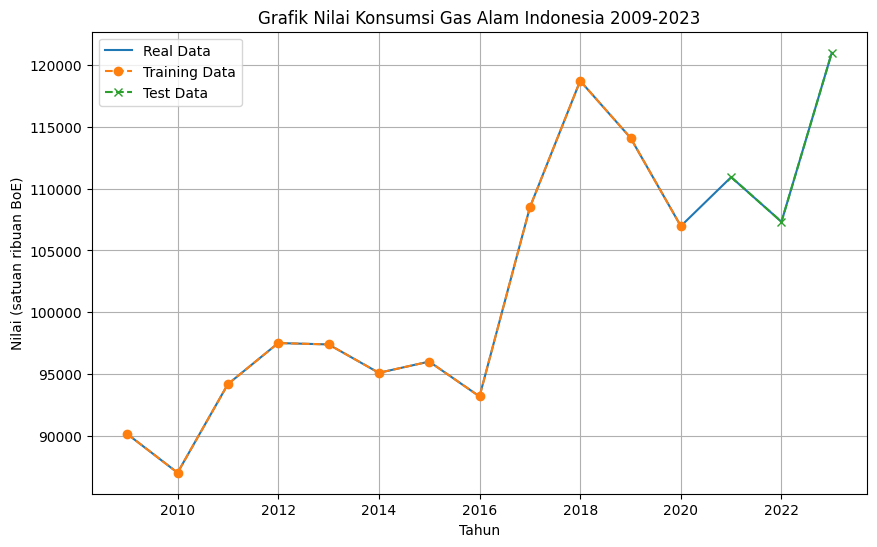

In [29]:
# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(timestamp_real, data_real, label='Real Data')
plt.plot(timestamp_real[:n], data_train, label='Training Data', marker='o', linestyle='--')
plt.plot(timestamp_real[n:], data_test, label='Test Data', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Tahun')
plt.ylabel('Nilai (satuan ribuan BoE)')
plt.title('Grafik Nilai Konsumsi Gas Alam Indonesia 2009-2023')

# Add legend
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

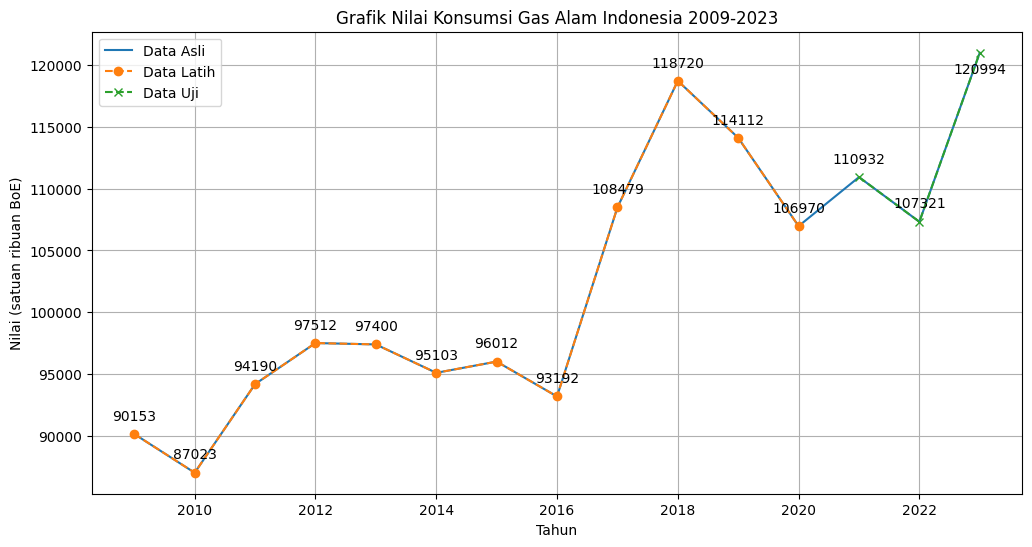

In [30]:
# prompt: the label for 2023 is kinda overlapping. how to fix that?

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(timestamp_real, data_real, label='Data Asli')
plt.plot(timestamp_real[:n], data_train, label='Data Latih', marker='o', linestyle='--')
plt.plot(timestamp_real[n:], data_test, label='Data Uji', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Tahun')
plt.ylabel('Nilai (satuan ribuan BoE)')
plt.title('Grafik Nilai Konsumsi Gas Alam Indonesia 2009-2023')

# Add legend
plt.legend()
plt.grid(True)

# Add data labels with adjustments for overlapping labels
for i, txt in enumerate(data_real):
    if i == len(data_real) -1: # Adjust for the last label
        plt.annotate(txt, (timestamp_real[i], data_real[i]), textcoords="offset points", xytext=(0, -15), ha='center')
    else:
        plt.annotate(txt, (timestamp_real[i], data_real[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Display the chart
plt.show()

# Build FDGM Model

In [31]:
# Menghitung barisan FOA dari X0 menggunakan nilai r
def r_FOA_series(X0, r):
    n = len(X0)
    X_r = np.zeros(n)
    for k in range(1, n + 1):
        sum_term = 0
        for i in range(1, k + 1):
            coefficient = gamma(r + k - i) / (gamma(k - i + 1) * gamma(r))
            sum_term += coefficient * X0[i - 1]
        X_r[k - 1] = sum_term
    return X_r

# Dapatkan parameter model FDGM dari nilai Xr
def compute_parameters_FDGM(X_r):
    n = len(X_r)
    Y = X_r[1:]
    B = np.vstack((X_r[:-1], np.ones(n - 1))).T
    beta = np.linalg.inv(B.T @ B) @ B.T @ Y
    return beta

# Hitung hasil prediksi Xr (Xr_hat) menggunakan parameter
def compute_Xr_hat(a, b, x0, steps): # Steps digunakan apabila ingin melakukan forecasting ke depan
    n = len(x0)
    Xr_hat = [x0[0]]
    a_float = float(a)
    b_float = float(b)
    for k in range(2, n + 1 + steps):
        term1 = (x0[0] - b_float / (1 - a_float)) * (a_float ** (k - 1))
        term2 = (b_float / (1 - a_float))
        Xr_hat.append(term1 + term2)
    return Xr_hat

# Hitung hasil prediksi X0 (X0_hat) menggunakan Xr_hat dan nilai r
def compute_X0_hat(Xr_hat, r):
    n = len(Xr_hat)
    restored_values = [Xr_hat[0]]
    for k in range(2, n + 1):
        restored_k = 0
        for i in range(k):
            coefficient = ((-1) ** i) * (gamma(r + 1) / ((gamma(i + 1) * gamma(r - i + 1))))
            restored_k += coefficient * Xr_hat[k - i - 1]
        restored_values.append(restored_k)
    return restored_values

# Hitung nilai evaluasi RMSE
def compute_rmse_gwo(actual, predicted):
    actual, predicted = np.array(actual[1:]), np.array(predicted[1:])  # Skip nilai pertama
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return rmse

In [32]:
list_r = [0.73, 0.25, 0.90, 0.58, 0.12]
for i in list_r:
  X_r = r_FOA_series(data_train, i)
  beta = compute_parameters_FDGM(X_r)
  xr_hat = compute_Xr_hat(beta[0], beta[1], X_r, 0)
  x0_hat = compute_X0_hat(xr_hat, i)
  print(f'RMSE untuk nilai r = {i} sebesar {compute_rmse_gwo(data_train, x0_hat[:n])}')

RMSE untuk nilai r = 0.73 sebesar 6291.984848245064
RMSE untuk nilai r = 0.25 sebesar 6368.5943094603535
RMSE untuk nilai r = 0.9 sebesar 5706.017914515609
RMSE untuk nilai r = 0.58 sebesar 6599.710627217202
RMSE untuk nilai r = 0.12 sebesar 6383.378601448723


# Do GWO Iteration to Obtain r

In [33]:
# Definisikan parameter GWO
np.random.seed(30)
max_iterations = 200 # Uji untuk masing-masing 50, 100, 150, 200
population_size = 50
dim = 1  # Hanya optimasi parameter r
data_used = data_train # Menggunakan data latih

# Inisialisasi populasi GWO
# Tiap serigala punya posisi dengan nilai r yang potensial
positions = np.random.uniform(low=0, high=1, size=(population_size, dim))
a_decay = np.linspace(2, 0, max_iterations)  # Menurun secara linear dari 2 ke 0

# Looping algoritma GWO
alpha_pos, beta_pos, delta_pos = None, None, None  # Posisi erbaik pertama, kedua, dan ketiga
alpha_score, beta_score, delta_score = float("inf"), float("inf"), float("inf")  # Nilai terbaik r
alpha_a, alpha_b = None, None  # Simpan juga nilai optimal a dan b secara bersamaan

# Simpan hasil tiap iterasi
results_per_iteration = []

for t in range(max_iterations):
    a = a_decay[t]

    for i in range(population_size):
        r = positions[i, 0]

        # Hitung r-FOA series
        r_foa_series = r_FOA_series(data_used, r)

        # Hitung parameters a dan b
        a_param, b_param = compute_parameters_FDGM(r_foa_series)

        # Hitung Xr_hat
        xr_hat = compute_Xr_hat(a_param, b_param, data_used, 0)

        # Hitung X0_hat
        x0_hat = compute_X0_hat(xr_hat, r)

        # Hitung fitness
        fitness = compute_rmse_gwo(data_used, x0_hat)

        # Update posisi alpha, beta, dan delta
        if fitness < alpha_score:
            alpha_score, alpha_pos = fitness, r
            alpha_a, alpha_b = a_param, b_param  # Simpan parameter terbaik
        elif fitness < beta_score:
            beta_score, beta_pos = fitness, r
        elif fitness < delta_score:
            delta_score, delta_pos = fitness, r

    # Update posisi semua serigala
    for i in range(population_size):
        A1, C1 = 2 * a * np.random.rand() - a, 2 * np.random.rand()
        A2, C2 = 2 * a * np.random.rand() - a, 2 * np.random.rand()
        A3, C3 = 2 * a * np.random.rand() - a, 2 * np.random.rand()

        # Update posisi berdasarkan serigala alpha, beta, dan delta
        D_alpha = abs(C1 * alpha_pos - positions[i, 0])
        D_beta = abs(C2 * beta_pos - positions[i, 0])
        D_delta = abs(C3 * delta_pos - positions[i, 0])

        X1 = alpha_pos - A1 * D_alpha
        X2 = beta_pos - A2 * D_beta
        X3 = delta_pos - A3 * D_delta

        # Rata-rata posisi update
        positions[i, 0] = np.clip((X1 + X2 + X3) / 3, 1e-5, np.inf)

    # Simpan hasil pada iterasi sekarang
    results_per_iteration.append({
        "iteration": t + 1,
        "rmse": alpha_score,
        "r": alpha_pos,
        "a": alpha_a,
        "b": alpha_b
    })

# Output hasil per iterasi
for result in results_per_iteration:
    print(f"Iteration {result['iteration']}: RMSE = {result['rmse']:.6f}, r = {result['r']:.6f}, a = {result['a']:.6f}, b = {result['b']:.6f}")

# Output parameter terbaik r dan bersamaan parameter a dan b
best_r = alpha_pos
best_a = alpha_a
best_b = alpha_b
print('----------------------------------')
print(f'Hasil optimal untuk jumlah iterasi sebanyak {max_iterations}:')
print('RMSE:', alpha_score)
print("Optimal r:", best_r)
print("Optimal a:", best_a)
print("Optimal b:", best_b)

Iteration 1: RMSE = 5497.898814, r = 0.994194, a = 1.023017, b = 86501.972035
Iteration 2: RMSE = 5493.332463, r = 1.003202, a = 1.024478, b = 87479.610246
Iteration 3: RMSE = 5493.332463, r = 1.003202, a = 1.024478, b = 87479.610246
Iteration 4: RMSE = 5493.332463, r = 1.003202, a = 1.024478, b = 87479.610246
Iteration 5: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 6: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 7: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 8: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 9: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 10: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 11: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 12: RMSE = 5492.381844, r = 1.008518, a = 1.025336, b = 88061.240143
Iteration 13: RMSE = 5492.381844, r = 1.008518, a = 1.025336,

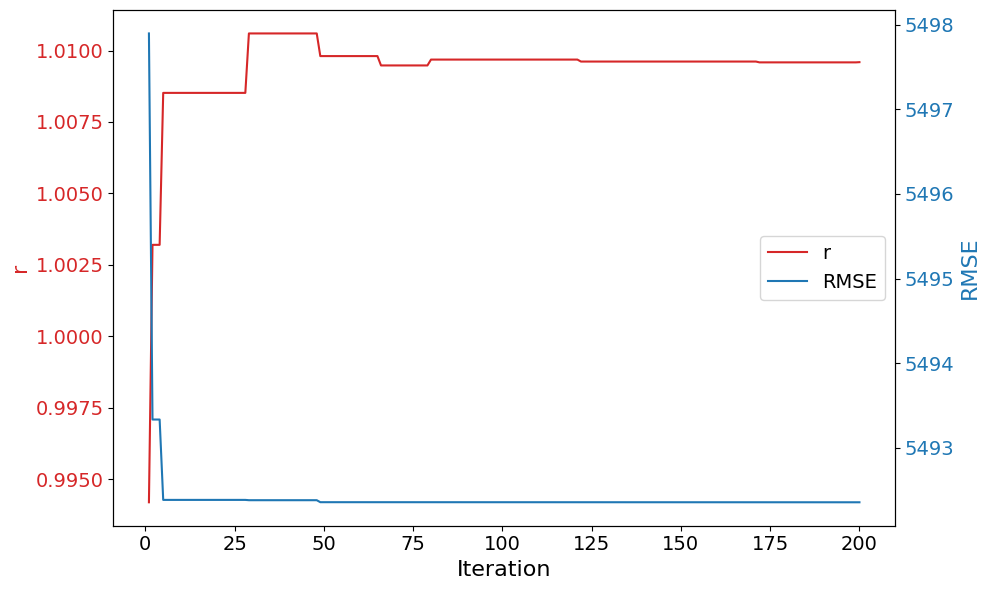

In [34]:
# Extract data for plotting
iterations = [result['iteration'] for result in results_per_iteration]
rmse_values = [result['rmse'] for result in results_per_iteration]
r_values = [result['r'] for result in results_per_iteration]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot r values on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration', fontsize=16)  # Perbesar ukuran label x-axis
ax1.set_ylabel('r', color=color, fontsize=16)  # Perbesar ukuran label y-axis
line1, = ax1.plot(iterations, r_values, color=color, label='r')
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)  # Perbesar ukuran tick labels
ax1.tick_params(axis='x', labelsize=14)  # Perbesar ukuran tick labels x-axis

# Create a second y-axis for RMSE values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color, fontsize=16)  # Perbesar ukuran label y-axis kedua
line2, = ax2.plot(iterations, rmse_values, color=color, label='RMSE')
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)  # Perbesar ukuran tick labels y-axis kedua

# Adjust layout
fig.tight_layout()

# Combine the legends from both axes
lines = [line1, line2]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='center right', fontsize=14)  # Perbesar ukuran legend

plt.show()

# Implement Dynamic Parameter of Gamma

In [35]:
# Konstruksi barisan parameter dinamis gamma
def construct_dynamic_gamma(data_ago, alpha):
    dynamic_gamma = []
    for k in range(len(data_ago) - 1):
        gamma_k = data_ago[k + 1] - alpha * data_ago[k]
        dynamic_gamma.append(gamma_k)
    return np.array(dynamic_gamma)

# 1-AGO untuk keperluan model EGM(1,1)
def generate_ago(data):
    return np.cumsum(data)

# Model EGM(1,1) yang sebenarnya sama dengan model GM(1,1)
def gm11_predict(data, steps):
    n = len(data)
    ago_data = generate_ago(data)
    B = np.vstack([-0.5 * (ago_data[:-1] + ago_data[1:]), np.ones(n - 1)]).T
    Y = data[1:]
    params = np.linalg.inv(B.T @ B) @ B.T @ Y
    a, b = params[0], params[1]
    print('Matriks B:', B) # B adalah matriks n x 2
    print('-------------')
    print('Matriks Y:', Y) # Y adalah vektor kolom n x 1
    print('-------------')
    print("Parameter a:", a)
    print("Parameter b:", b)
    print('-------------')

    # GM(1,1) prediction formula X1_hat
    def gm11_formula(k):
        gamma1 = data[0]
        gamma1_term = (gamma1 - b / a) * np.exp(-a * k)
        return gamma1_term + b / a

    # Restored values formula X0_hat
    def restored_value(k):
        gamma1 = data[0]
        gamma1_term = (gamma1 - b / a) * np.exp(-a * k)
        return (1 - np.exp(a)) * gamma1_term
    cumulative_predictions = [gm11_formula(k) for k in range(1, n + steps)]
    restored_predictions = [restored_value(k) for k in range(1, n + steps)]
    restored_predictions.insert(0, data[0])
    return np.array(restored_predictions)

# Hitung Xr_hat berdasarkan parameter dinamis gamma
def predict_dynamic_fdgm(data, steps, alpha, gamma_seq):
    n = len(data)
    xr_hat = [data[0]]  # \hat{x}^{(r)}(1) = x^{(0)}(1)
    for k in range(2, n + 1 + steps):
      gamma_k = gamma_seq[k - 2]
      term1 = (data[0] - gamma_k / (1 - alpha)) * (alpha ** (k - 1))
      term2 = (gamma_k / (1 - alpha))
      xr_hat.append(term1 + term2)
    return xr_hat

In [36]:
# r-FOA-series, untuk k = 1,2,...,12
new_r_FOA_series = r_FOA_series(data_train, best_r)
print('Barisan r-AGO-series : ')
for val1 in new_r_FOA_series:
  print(f"{val1:.4f}")

print('----------------------------------')

# Deret P gamma, untuk n = 1,2,...,12-1
P_gamma = construct_dynamic_gamma(new_r_FOA_series, best_a)
print('Barisan P_gamma: ')
for val2 in P_gamma:
  print(f"{val2:.4f}")

print('----------------------------------')

# Deret P_gamma_hat, untuk n = 1,2,...,12-1, lalu steps sebanyak 3
P_gamma_hat = gm11_predict(P_gamma, len(data_real)-n) # len(data_real)-n adalah jumlah steps
print('Barisan P_gamma_hat: ')
for val3 in P_gamma_hat:
  print(f"{val3:.4f}")

print('----------------------------------')

# Hitung Xr_hat
new_xr_hat = predict_dynamic_fdgm(data_train, len(data_real)-n, best_a, P_gamma_hat)
print('Barisan Xr_hat: ')
for val4 in new_xr_hat:
  print(f"{val4:.4f}")

print('----------------------------------')

# Hitung X0_hat
new_x0_hat = compute_X0_hat(new_xr_hat, best_r)
print('Barisan X0_hat: ')
for val5 in new_x0_hat:
  print(f"{val5:.4f}")

Barisan r-AGO-series : 
90153.0000
178040.8957
273502.3598
372631.8841
471925.8802
569129.9596
667389.9356
762970.6528
873932.6437
995376.0269
1112470.9923
1222559.6241
----------------------------------
Barisan P_gamma: 
85588.1085
90919.6723
92152.5273
89788.2223
85165.3335
83741.5710
78555.7175
91498.7441
99149.5154
91703.0984
81709.6928
----------------------------------
Matriks B: [[-1.31047945e+05  1.00000000e+00]
 [-2.22584044e+05  1.00000000e+00]
 [-3.13554419e+05  1.00000000e+00]
 [-4.01031197e+05  1.00000000e+00]
 [-4.85484649e+05  1.00000000e+00]
 [-5.66633294e+05  1.00000000e+00]
 [-6.51660524e+05  1.00000000e+00]
 [-7.46984654e+05  1.00000000e+00]
 [-8.42410961e+05  1.00000000e+00]
 [-9.29117357e+05  1.00000000e+00]]
-------------
Matriks Y: [90919.6722976  92152.52729587 89788.22232662 85165.33345666
 83741.57102112 78555.71748392 91498.74408971 99149.51542438
 91703.09840002 81709.69283136]
-------------
Parameter a: 0.0017580652057240242
Parameter b: 89368.51545004366
-

# Validation

In [37]:
# Evaluasi pada data training

def compute_mape(actual, predicted):
    actual, predicted = np.array(actual[1:]), np.array(predicted[1:])  # Skip nilai pertama
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return round(mape, 4)

def compute_mae(actual, predicted):
    actual, predicted = np.array(actual[1:]), np.array(predicted[1:])  # Skip nilai pertama
    mae = np.mean(np.abs(actual - predicted))
    return round(mae, 4)

def compute_rmse(actual, predicted):
    actual, predicted = np.array(actual[1:]), np.array(predicted[1:])  # Skip nilai pertama
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return round(rmse, 4)

# Evaluasi pada data testing

def compute_mape_test(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return round(mape, 4)

def compute_mae_test(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mae = np.mean(np.abs(actual - predicted))
    return round(mae, 4)

def compute_rmse_test(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return round(rmse, 4)

In [38]:
# error relatif

def each_error(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("Panjang data aktual dan prediksi harus sama.")

    percentage_error = [
        abs(pred - act) / act * 100
        for act, pred in zip(actual, predicted)
    ]
    return percentage_error

In [39]:
# Memanggil fungsi
errors = each_error(data_train, new_x0_hat[:n])

# Menampilkan hasil
for i, error in enumerate(errors, start=1):
    print(f"Data ke-{i}: Error = {error:.4f}%")

Data ke-1: Error = 0.0000%
Data ke-2: Error = 0.0000%
Data ke-3: Error = 1.9770%
Data ke-4: Error = 3.5534%
Data ke-5: Error = 1.5101%
Data ke-6: Error = 2.9303%
Data ke-7: Error = 4.0745%
Data ke-8: Error = 9.4800%
Data ke-9: Error = 3.9496%
Data ke-10: Error = 10.3555%
Data ke-11: Error = 4.7251%
Data ke-12: Error = 3.8393%


In [40]:
# Memanggil fungsi
errors = each_error(data_test, new_x0_hat[n:])

# Menampilkan hasil
for i, error in enumerate(errors, start=1):
    print(f"Data ke-{i + n}: Error = {error:.4f}%")

Data ke-13: Error = 2.3117%
Data ke-14: Error = 8.0675%
Data ke-15: Error = 2.0399%


In [41]:
print('MAPE training:', compute_mape(data_train, new_x0_hat[:n]))
print('MAE training:', compute_mae(data_train, new_x0_hat[:n]))
print('RMSE training:', compute_rmse(data_train, new_x0_hat[:n]))
print('----------------------------------')
print("MAPE testing : ", compute_mape_test(data_test, new_x0_hat[n:]))
print("MAE testing : ", compute_mae_test(data_test, new_x0_hat[n:]))
print("RMSE testing : ", compute_rmse_test(data_test, new_x0_hat[n:]))

MAPE training: 4.2177
MAE training: 4400.7977
RMSE training: 5511.9517
----------------------------------
MAPE testing :  4.1397
MAE testing :  4563.5437
RMSE testing :  5404.656


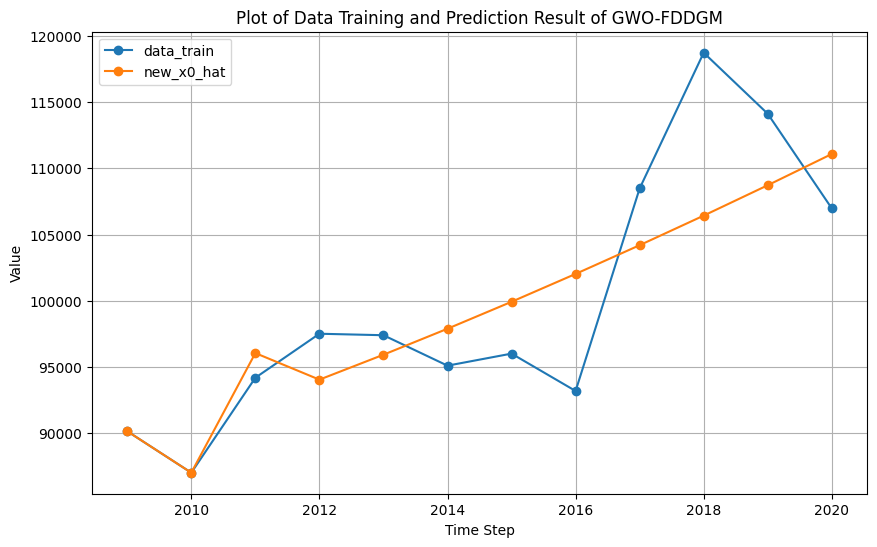

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(timestamp_real[:n], data_train, label='data_train',  marker='o')
plt.plot(timestamp_real[:n], new_x0_hat[:n], label='new_x0_hat',  marker='o')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Plot of Data Training and Prediction Result of GWO-FDDGM')
plt.legend()
plt.grid(True)
plt.show()

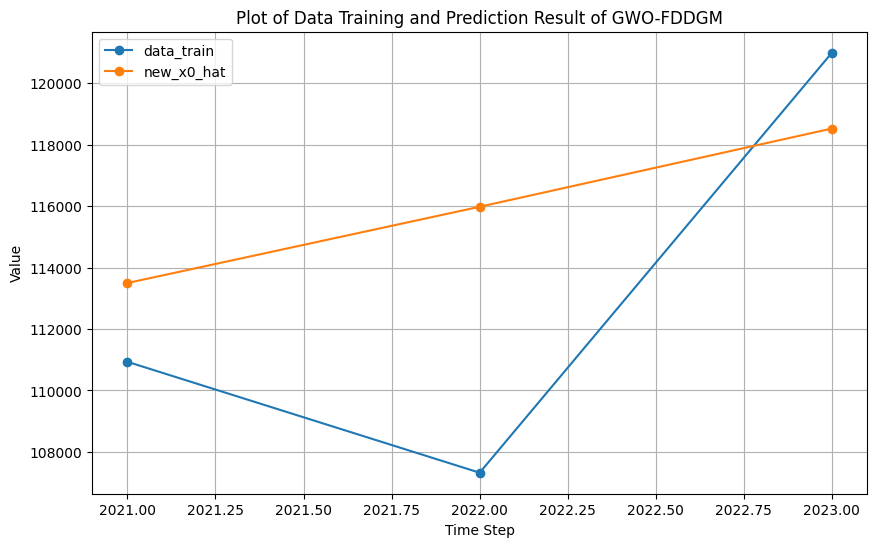

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(timestamp_real[n:], data_test, label='data_train',  marker='o')
plt.plot(timestamp_real[n:], new_x0_hat[n:], label='new_x0_hat',  marker='o')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Plot of Data Training and Prediction Result of GWO-FDDGM')
plt.legend()
plt.grid(True)
plt.show()

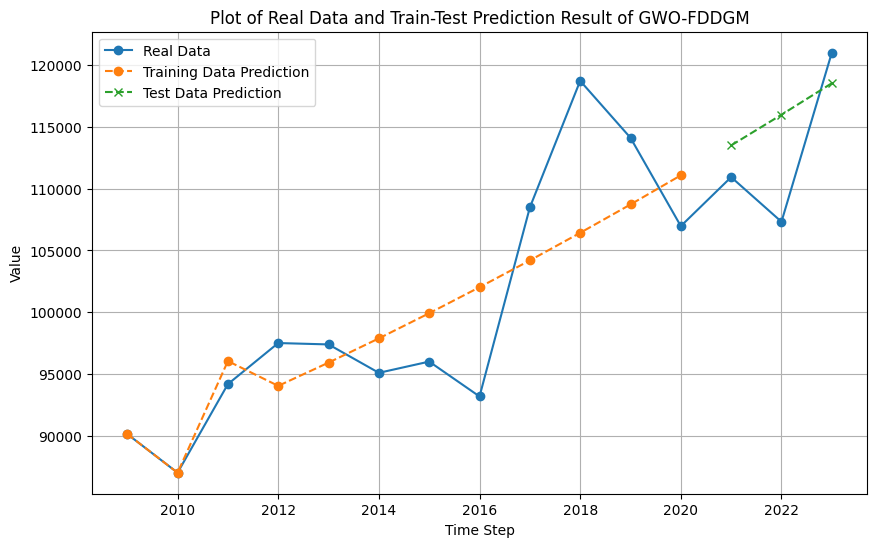

In [44]:
import matplotlib.pyplot as plt

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(timestamp_real, data_real, label='Real Data',  marker='o')
plt.plot(timestamp_real[:n], new_x0_hat[:n], label='Training Data Prediction', marker='o', linestyle='--')
plt.plot(timestamp_real[n:], new_x0_hat[n:], label='Test Data Prediction', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Plot of Real Data and Train-Test Prediction Result of GWO-FDDGM')

# Add legend
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

# Future Forecasting for 3 Years ahead (2024-2026)

In [45]:
# Define GWO hyperparameters
np.random.seed(30)
max_iterations = 500
population_size = 50
dim = 1  # Only optimizing parameter r
data_used = data_real

# Initialize the GWO population
# Each wolf has a position corresponding to a potential value of r
positions = np.random.uniform(low=0, high=1, size=(population_size, dim))
a_decay = np.linspace(2, 0, max_iterations)  # a decreases linearly from 2 to 0

# GWO algorithm loop
alpha_pos, beta_pos, delta_pos = None, None, None  # Best, second-best, and third-best positions
alpha_score, beta_score, delta_score = float("inf"), float("inf"), float("inf")  # Best scores
alpha_a, alpha_b = None, None  # To store optimal values of a, b, and c

# Store results for each iteration
results_per_iteration_f = []

for t in range(max_iterations):
    a = a_decay[t]

    for i in range(population_size):
        r = positions[i, 0]

        # Generate r-FOA series
        r_foa_series = r_FOA_series(data_used, r)

        # Compute parameters a, b, c
        a_param, b_param = compute_parameters_FDGM(r_foa_series)

        # Compute the simulation value
        simulated_value = compute_Xr_hat(a_param, b_param, data_used, 0 )

        # Compute x_hat based on simulated value
        x_hat = compute_X0_hat(simulated_value, r)

        # Calculate fitness
        fitness = compute_rmse_gwo(data_used, x_hat)

        # Update alpha, beta, and delta positions
        if fitness < alpha_score:
            alpha_score, alpha_pos = fitness, r
            alpha_a, alpha_b = a_param, b_param  # Save the best parameters
        elif fitness < beta_score:
            beta_score, beta_pos = fitness, r
        elif fitness < delta_score:
            delta_score, delta_pos = fitness, r

    # Update positions of all wolves
    for i in range(population_size):
        A1, C1 = 2 * a * np.random.rand() - a, 2 * np.random.rand()
        A2, C2 = 2 * a * np.random.rand() - a, 2 * np.random.rand()
        A3, C3 = 2 * a * np.random.rand() - a, 2 * np.random.rand()

        # Position updates with respect to alpha, beta, and delta wolves
        D_alpha = abs(C1 * alpha_pos - positions[i, 0])
        D_beta = abs(C2 * beta_pos - positions[i, 0])
        D_delta = abs(C3 * delta_pos - positions[i, 0])

        X1 = alpha_pos - A1 * D_alpha
        X2 = beta_pos - A2 * D_beta
        X3 = delta_pos - A3 * D_delta

        # Average position update
        positions[i, 0] = np.clip((X1 + X2 + X3) / 3, 1e-5, np.inf)

    # Store results for the current iteration
    results_per_iteration_f.append({
        "iteration": t + 1,
        "rmse": alpha_score,
        "r": alpha_pos,
        "a": alpha_a,
        "b": alpha_b
    })

# Output results per iteration
for result in results_per_iteration_f:
    print(f"Iteration {result['iteration']}: RMSE = {result['rmse']:.6f}, r = {result['r']:.6f}, a = {result['a']:.6f}, b = {result['b']:.6f}")

# Output the best parameter r and its corresponding parameters a, b, and c
best_r_f = alpha_pos
best_a_f = alpha_a
best_b_f = alpha_b
print('----------------------------------')
print('Hasil optimal:')
print('RMSE:', alpha_score)
print("Optimal r:", best_r_f)
print("Optimal a:", best_a_f)
print("Optimal b:", best_b_f)

Iteration 1: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 2: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 3: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 4: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 5: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 6: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 7: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 8: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 9: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 10: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 11: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 12: RMSE = 5498.019531, r = 0.962608, a = 1.015275, b = 84126.377058
Iteration 13: RMSE = 5498.019531, r = 0.962608, a = 1.015275,

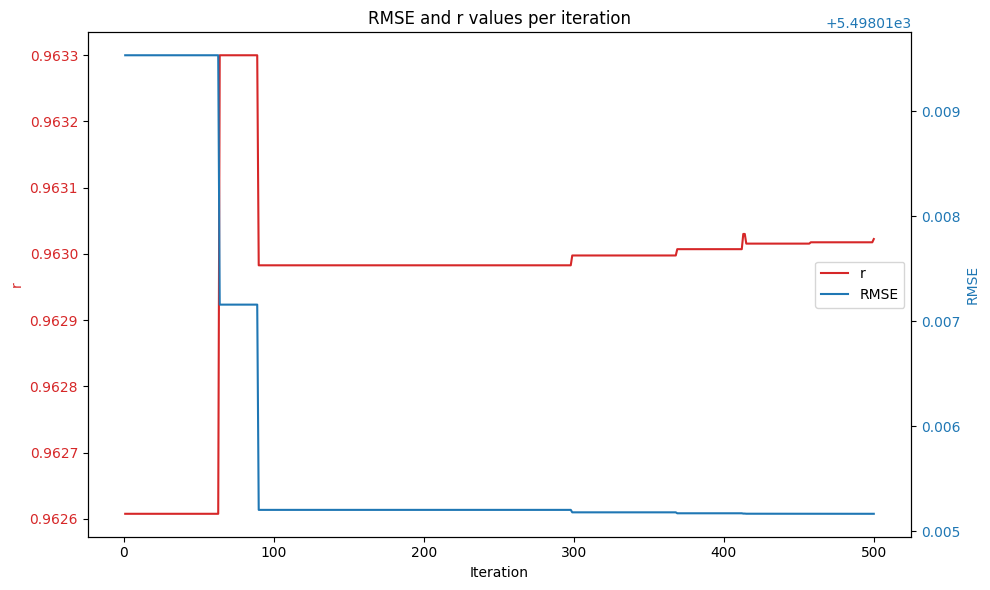

In [46]:
# Extract data for plotting
iterations = [result['iteration'] for result in results_per_iteration_f]
rmse_values = [result['rmse'] for result in results_per_iteration_f]
r_values = [result['r'] for result in results_per_iteration_f]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot r values on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('r', color=color)
line1, = ax1.plot(iterations, r_values, color=color, label='r') #Added label and ,
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for RMSE values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color)
line2, = ax2.plot(iterations, rmse_values, color=color, label='RMSE') #Added label and ,
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title('RMSE and r values per iteration')
fig.tight_layout()  # Adjust layout to prevent overlapping labels

# Combine the legends from both axes
lines = [line1, line2]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='center right') # Added legend

plt.show()

In [47]:
new_r_FOA_series_f = r_FOA_series(data_real, best_r_f)
print('Deret r-AGO-series : ')
for a in new_r_FOA_series_f:
  print(f"{a:.4f}")

print('---------------------------------')

P_gamma_f = construct_dynamic_gamma(new_r_FOA_series_f, best_a_f)
print('Deret P_gamma: ')
for b in P_gamma_f:
  print(f"{b:.4f}")

print('---------------------------------')

P_gamma_hat_f = gm11_predict(P_gamma_f, 3)
print('Deret P_gamma_hat: ')
for c in P_gamma_hat_f:
  print(f"{c:.4f}")

print('---------------------------------')

new_xr_hat_f = predict_dynamic_fdgm(data_real, 3, best_a_f, P_gamma_hat_f)
print('Deret Xr_hat: ')
for d in new_xr_hat_f:
  print(f"{d:.4f}")

print('---------------------------------')

new_x0_hat_f = compute_X0_hat(new_xr_hat_f, best_r_f)
print('Deret X0_hat: ')
for e in new_x0_hat_f:
  print(f"{e:.4f}")

Deret r-AGO-series : 
90153.0000
173842.3607
263209.2765
354638.5663
444963.8300
532263.9184
619970.6924
704371.5381
803748.8057
912487.1650
1015673.6141
1111257.8845
1210649.8136
1306041.3469
1414920.6891
---------------------------------
Deret P_gamma: 
82307.2162
86701.7214
87394.0023
84888.2648
80478.3040
79546.5832
74896.0138
88578.4779
96416.0070
89197.0182
80012.8779
82355.1246
76830.9414
88856.2933
---------------------------------
Matriks B: [[-1.25658077e+05  1.00000000e+00]
 [-2.12705939e+05  1.00000000e+00]
 [-2.98847072e+05  1.00000000e+00]
 [-3.81530357e+05  1.00000000e+00]
 [-4.61542800e+05  1.00000000e+00]
 [-5.38764099e+05  1.00000000e+00]
 [-6.20501345e+05  1.00000000e+00]
 [-7.12998587e+05  1.00000000e+00]
 [-8.05805100e+05  1.00000000e+00]
 [-8.90410048e+05  1.00000000e+00]
 [-9.71594049e+05  1.00000000e+00]
 [-1.05118708e+06  1.00000000e+00]
 [-1.13403070e+06  1.00000000e+00]]
-------------
Matriks Y: [86701.72142149 87394.00229302 84888.26481621 80478.30403012
 79

In [48]:
data_combined = data_real.tolist() + new_x0_hat_f[15:]

timestamp_future = [2024, 2025, 2026]
timestamp_combined = timestamp_real.tolist() + timestamp_future

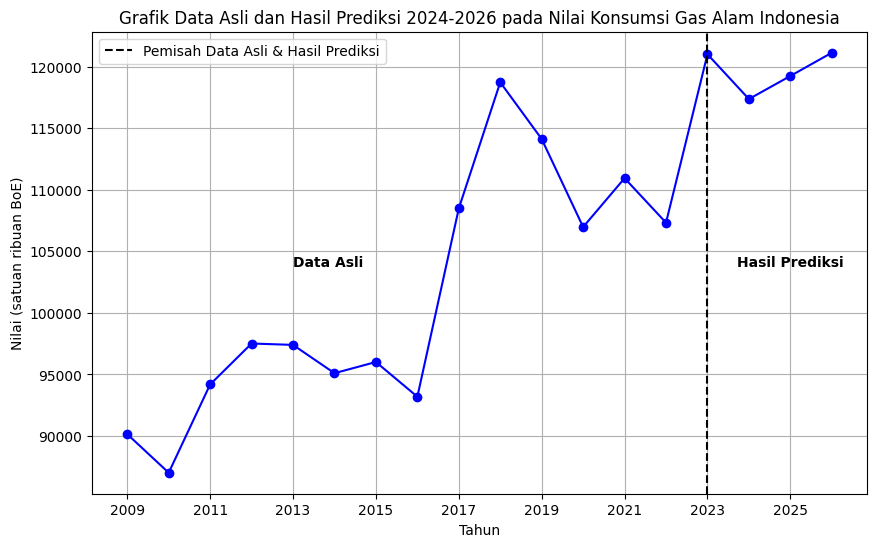

In [49]:
# Create the line chart with a split
plt.figure(figsize=(10, 6))

# Plot real data (left part)
plt.plot(timestamp_combined, data_combined, marker='o', color='blue')

# Add a vertical line to separate the areas
plt.axvline(x=timestamp_real[14], color='black', linestyle='--', label='Pemisah Data Asli & Hasil Prediksi')

# Customize x-axis ticks
xticks = np.arange(min(timestamp_real), max(timestamp_real.tolist() + timestamp_future) + 1, 2)
plt.xticks(xticks, rotation=0, ha="center")

def middle(data):
    return (min(data) + max(data)) / 2

# Add text annotations for simulasi and prediksi areas
plt.text(timestamp_combined[4], middle(data_combined), 'Data Asli', ha='left', va='center', weight='semibold')
plt.text(timestamp_combined[-2], middle(data_combined), 'Hasil Prediksi', ha='center', va='center', weight='semibold')

# Add labels and title
plt.xlabel('Tahun')
plt.ylabel('Nilai (satuan ribuan BoE)')
plt.title('Grafik Data Asli dan Hasil Prediksi 2024-2026 pada Nilai Konsumsi Gas Alam Indonesia')

# Add legend
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

<ipython-input-50-7f877a13c6cb>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


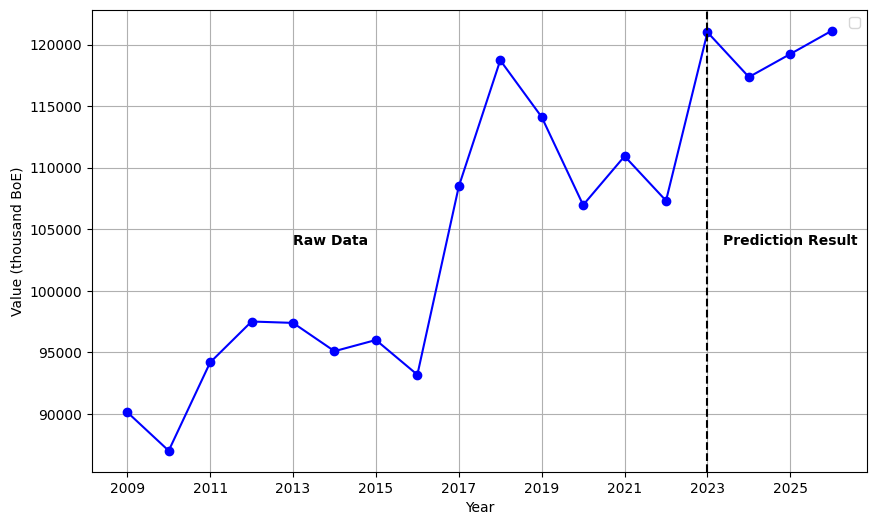

In [50]:
# Create the line chart with a split
plt.figure(figsize=(10, 6))

# Plot real data (left part)
plt.plot(timestamp_combined, data_combined, marker='o', color='blue')

# Add a vertical line to separate the areas
plt.axvline(x=timestamp_real[14], color='black', linestyle='--')

# Customize x-axis ticks
xticks = np.arange(min(timestamp_real), max(timestamp_real.tolist() + timestamp_future) + 1, 2)
plt.xticks(xticks, rotation=0, ha="center")

def middle(data):
    return (min(data) + max(data)) / 2

# Add text annotations for simulasi and prediksi areas
plt.text(timestamp_combined[4], middle(data_combined), 'Raw Data', ha='left', va='center', weight='semibold')
plt.text(timestamp_combined[-2], middle(data_combined), 'Prediction Result', ha='center', va='center', weight='semibold')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Value (thousand BoE)')

# Add legend
plt.legend()
plt.grid(True)

# Display the chart
plt.show()